In [ ]:
!cd content/CMU/*

/bin/bash: line 0: cd: content/CMU/*: No such file or directory


In [ ]:
!git clone https://github.com/resemble-ai/Resemblyzer.git

Cloning into 'Resemblyzer'...
remote: Enumerating objects: 602, done.
remote: Total 602 (delta 0), reused 0 (delta 0), pack-reused 602
Receiving objects: 100% (602/602), 101.46 MiB | 36.15 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [ ]:
%cd /content/Resemblyzer/

/content/Resemblyzer


In [ ]:
!pip install -r  /content/Resemblyzer/requirements_demos.txt

     |████████████████████████████████| 66 kB 2.4 MB/s 
     |████████████████████████████████| 78 kB 5.4 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 23.0 MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72371 sha256=7621f4ae82593fcd07bed8d20dbae14244801d282e036e3ccae3bc29a5c95bee
  Stored in directory: /root/.cache/pip/wheels/11/f9/67/a3158d131f57e1c0a7d8d966a707d4a2fb27567a4fe47723ad
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=fbd02a1c9f53568e1fc1325fe365404b2e64401b5d3e3300c61e00db30c1c037
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=ba9cc8bd29661af264bf40ab0438f52001799bd4db06a4047b8d6e9d3370d702
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffe

In [ ]:
!mkdir /content/new

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
from pathlib import Path

#give the file path to your audio file (Noagenda-0690-2015-01-25-Noagenda-0690-2015-01-25 from 13:37 to 15:12)
audio_file_path = '/content/new/noagenda-extract.wav'
wav_fpath = Path(audio_file_path)

wav = preprocess_wav(wav_fpath)
encoder = VoiceEncoder("cpu")
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)
print(cont_embeds.shape)

Loaded the voice encoder model on cpu in 0.04 seconds.
(1548, 256)


In [ ]:
!pip install spectralcluster

In [ ]:
from spectralcluster import configs

labels = configs.icassp2018_clusterer.predict(cont_embeds)

#labels = clusterer.predict(cont_embeds)

In [ ]:
from spectralcluster import RefinementOptions
from spectralcluster import ThresholdType
from spectralcluster import ICASSP2018_REFINEMENT_SEQUENCE

refinement_options = RefinementOptions(
    gaussian_blur_sigma=1,
    p_percentile=0.95,
    thresholding_soft_multiplier=0.01,
    thresholding_type=ThresholdType.RowMax,
    refinement_sequence=ICASSP2018_REFINEMENT_SEQUENCE)

In [ ]:
from spectralcluster import SpectralClusterer

clusterer = SpectralClusterer(
    min_clusters=2,
    max_clusters=7,
    autotune=None,
    laplacian_type=None,
    refinement_options=refinement_options,
    custom_dist="cosine")
print("Done")
labels = clusterer.predict(cont_embeds)

Done


In [ ]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from spectralcluster import AutoTune

autotune = AutoTune(
    p_percentile_min=0.60,
    p_percentile_max=0.95,
    init_search_step=0.01,
    search_level=3)

In [ ]:
def create_labelling(labels,wav_splits):
    from resemblyzer import sampling_rate
    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    labelling = []
    start_time = 0

    for i,time in enumerate(times):
        if i>0 and labels[i]!=labels[i-1]:
            temp = [str(labels[i-1]),start_time,time]
            labelling.append(tuple(temp))
            start_time = time
        if i==len(times)-1:
            temp = [str(labels[i]),start_time,time]
            labelling.append(tuple(temp))

    return labelling

In [ ]:
labelling = create_labelling(labels,wav_splits)

In [ ]:
labelling

[('0', 0, 16.34),
 ('1', 16.34, 17.78),
 ('0', 17.78, 22.4),
 ('1', 22.4, 24.14),
 ('0', 24.14, 27.86),
 ('1', 27.86, 30.38),
 ('0', 30.38, 57.74),
 ('1', 57.74, 62.06),
 ('0', 62.06, 69.38),
 ('1', 69.38, 69.5),
 ('0', 69.5, 70.94),
 ('1', 70.94, 74.9),
 ('0', 74.9, 79.76),
 ('1', 79.76, 80.18),
 ('0', 80.18, 93.62)]

In [ ]:
pip install pydub

In [ ]:
from pydub import AudioSegment

def mp3_to_wav(audio_file_path):
    sound = AudioSegment.from_mp3(audio_file_path)
    audio_file_path = audio_file_path.split('.')[0] + '.wav'
    sound.export(audio_file_path, format="wav")
    return audio_file_path

#audio_file_path = mp3_to_wav(audio_file_path)
#print(audio_file_path)

In [ ]:
pip install spectralcluster

In [ ]:
!pip install ffmpeg-python

In [ ]:
import ffmpeg
def create_output_files(path):
    # For each tuple in the labelling file, extract ele[0] as the speaker
    # label, ele[1] as the start time, and ele[2] as the end time
    num = 1
    input = ffmpeg.input(path)
    for ele in labelling:
        audio_trim = input.audio.filter('atrim', start=ele[1], end=ele[2])
        numstr = str(num)
        while len(numstr) < 4:
            numstr = "0" + numstr
        output = ffmpeg.output(audio_trim, "/content/extract{}.wav".format(numstr))
        output.run(capture_stdout=True, capture_stderr=True, overwrite_output=True)
        num += 1


In [ ]:
try:
    create_output_files(audio_file_path)
except ffmpeg.Error as e:
    print(e.stderr)  

In [ ]:
!pip install SpeechRecognition

     |████████████████████████████████| 32.8 MB 1.6 MB/s 


In [ ]:
import speech_recognition as sr
def transcribe_audio(path):
    r = sr.Recognizer()
    audio_file = sr.AudioFile(path)
    with audio_file as source:
        r.adjust_for_ambient_noise(source)
        audio = r.record(source)
    try:
        res = r.recognize_google(audio, language="en-US")
    except sr.UnknownValueError:
        res = "(The speech is unintelligible)"
    except sr.RequestError:
        res = "(The speech recognition operation failed)"
    return res

In [ ]:
import os
import os.path
list_dir = os.listdir("/content")
i = 0
for e in list_dir:
    if e.startswith('extract'):
        path = os.path.join("/content", e)
        transcription = transcribe_audio(path)
        print("Speaker {}: {}".format(labelling[i][0], transcription))
        i += 1

Speaker 0: (The speech is unintelligible)
Speaker 1: (The speech is unintelligible)
Speaker 0: (The speech is unintelligible)
Speaker 1: the commitments
Speaker 0: negotiate
Speaker 1: I have instability in financial markets believe that a couple of years ago
Speaker 0: (The speech is unintelligible)
Speaker 1: it'll be between
Speaker 0: (The speech is unintelligible)
Speaker 1: Eurasian or renegotiate
Speaker 0: (The speech is unintelligible)
Speaker 1: it's true I heard it too did you get this from TV or from the web
Speaker 0: commitment
Speaker 1: (The speech is unintelligible)
Speaker 0: (The speech is unintelligible)


In [ ]:
!pip install pyannote.metrics

To calculate the DER and the JER, several tools can be used such as *dscore* or *pyannote*

# Dscore
To use *dscore*, run the following commands.

In [ ]:
!git clone https://github.com/nryant/dscore.git

fatal: destination path 'dscore' already exists and is not an empty directory.


In [ ]:
%cd ../dscore

/content/dscore


In [ ]:
!pip install -r requirements.txt

  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=896a15e34262e5ed51f8664527cb236e81e4bba51a03d416f7bbcc42c7288cb6
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


The script *score.py* takes one or several RTTM files for the reference and the system.

Rich Transcription Time Marked (RTTM) files are space-delimited text files containing one turn per line, each line containing ten fields:

Type -- segment type; should always by SPEAKER

File ID -- file name; basename of the recording minus extension (e.g., rec1_a)

Channel ID -- channel (1-indexed) that turn is on; should always be 1

Turn Onset -- onset of turn in seconds from beginning of recording

Turn Duration -- duration of turn in seconds

Orthography Field -- should always be ```<NA>```

Speaker Type -- should always be ```<NA>```

Speaker Name -- name of speaker of turn; should be unique within scope of each file

Confidence Score -- system confidence (probability) that information is correct; should always be ```<NA>```

Signal Lookahead Time -- should always be ```<NA>```

## Example
```
SPEAKER CMU_20020319-1400_d01_NONE 1 130.430000 2.350 <NA> <NA> juliet <NA> <NA>
SPEAKER CMU_20020319-1400_d01_NONE 1 157.610000 3.060 <NA> <NA> tbc <NA> <NA>
SPEAKER CMU_20020319-1400_d01_NONE 1 130.490000 0.450 <NA> <NA> chek <NA> <NA>
```

You can then execute *score.py* with the reference files and the system files

In [ ]:
%cd /content/dscore/

In [ ]:
!python score.py -r ../CMU_20030109-1600.sdm.overlap.rttm -s ../out.rttm

# PyAnnote

First, install PyAnnote with the following command:

# New Section

**Start to execute here: don't take into account the cells above (except for Resemblyzer)**

In [ ]:
!pip install pyannote.metrics

     |████████████████████████████████| 49 kB 3.5 MB/s 
     |████████████████████████████████| 59 kB 8.9 MB/s 
     |████████████████████████████████| 41 kB 331 kB/s 
     |████████████████████████████████| 130 kB 42.0 MB/s 


It seems that you have to add the segments directly in the code. The letters ```A```, ```B```, ```C``` and ```D``` identify the different speakers.

In [ ]:
metric = DiarizationErrorRate()
metric(reference, hypothesis, detailed=True)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'confusion': 7.0,
 'correct': 22.0,
 'diarization error rate': 0.5161290322580645,
 'false alarm': 7.0,
 'missed detection': 2.0,
 'total': 31.0}

In [ ]:
import librosa
import librosa.display # You need this in librosa to be able to plot
import os, sys, glob
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

#give the file path to your audio file
audio_file_path = '/content/CMU/*'
clip_dir=glob.glob(audio_file_path)

In [ ]:
!pip install spectralcluster

In [ ]:
from spectralcluster import SpectralClusterer

clusterer = SpectralClusterer(
    min_clusters=2,
    max_clusters=7,
    autotune=None,
    laplacian_type=None,
    refinement_options=None,
    custom_dist="cosine")



In [ ]:
def create_labelling(labels,wav_splits, prefix="", output_file_name="/content/labelling.txt"):
    from resemblyzer import sampling_rate
    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    start_time = 0
    with open(output_file_name, 'a+') as f_out:
        for i,time in enumerate(times):
            if i>0 and labels[i]!=labels[i-1]:
                temp = [prefix + str(labels[i-1]),start_time,time]
                f_out.write("{} {} {}\n".format(temp[0], temp[1], temp[2]))
                start_time = time
            if i==len(times)-1:
                temp = [prefix + str(labels[i]),start_time,time]
                f_out.write("{} {} {}\n".format(temp[0], temp[1], temp[2]))

  

In [ ]:
%cd Resemblyzer/

/content/Resemblyzer


In [ ]:
def labelling_to_rttm(input_file, output_file):
    with open(input_file, 'r') as f_in:
        with open(output_file, 'a+') as f_out:
            lines = f_in.readlines()
            for l in lines:
                fields = l.split(' ')
                if len(fields) == 3:
                    speaker = fields[0]
                    turn_onset = float(fields[1])
                    turn_duration = float(fields[2][:-1]) - turn_onset
                    output_line = "SPEAKER {} 1 {:.3f} {:.3f} <NA> <NA> {} <NA> <NA>".format(speaker, turn_onset, turn_duration, speaker)
                    f_out.write(output_line + "\n")

In [ ]:
def time_labelling_to_rttm(input_file, output_file):
    with open(input_file, 'r') as f_in:
        with open(output_file, 'a+') as f_out:
            lines = f_in.readlines()
            for l in lines:
                fields = l.split()
                print(fields)
                if len(fields) == 3:
                    print(fields)
                    speaker = fields[0]
                    turn_onset= (datetime.datetime.strptime((fields[1]).strip().replace('\n',''),"%H:%M:%S,%f") - datetime.datetime(1900, 1, 1)).total_seconds()
                    #turn_onset = float(fields[1])
                    print(turn_onset)
                    turn_duration = (datetime.datetime.strptime((fields[2]).strip().replace('\n',''),"%H:%M:%S,%f") - datetime.datetime(1900, 1, 1)).total_seconds() -turn_onset
                    #turn_onset =- turn_onset
                    output_line = "SPEAKER {} 1 {:.3f} {:.3f} <NA> <NA> {} <NA> <NA>".format(speaker, turn_onset, turn_duration, speaker)
                    f_out.write(output_line + "\n")

In [ ]:
time_labelling_to_rttm("annotation", "/content/out.rttm")

['Speaker1', '00:00:00,630', '00:00:07,020']
['Speaker1', '00:00:00,630', '00:00:07,020']
0.63
['Speaker1', '00:00:09,719', '00:00:15,449']
['Speaker1', '00:00:09,719', '00:00:15,449']
9.719
['Speaker1', '00:00:16,560', '00:00:36,630']
['Speaker1', '00:00:16,560', '00:00:36,630']
16.56
['Speaker2', '00:00:42,810', '00:00:46,290']
['Speaker2', '00:00:42,810', '00:00:46,290']
42.81
['Speaker2', '00:00:51,300', '00:01:01,020']
['Speaker2', '00:00:51,300', '00:01:01,020']
51.3
['Speaker2', '00:00:55,830', '00:01:01,020']
['Speaker2', '00:00:55,830', '00:01:01,020']
55.83
['Speaker2', '00:01:03,180', '00:01:07,050']
['Speaker2', '00:01:03,180', '00:01:07,050']
63.18
['Speaker2', '00:01:09,780', '0:01:24,180']
['Speaker2', '00:01:09,780', '0:01:24,180']
69.78
['Speaker2', '00:01:24,180', '00:01:58,290']
['Speaker2', '00:01:24,180', '00:01:58,290']
84.18
['Speaker3', '00:01:58,290', '00:02:01,740']
['Speaker3', '00:01:58,290', '00:02:01,740']
118.29
['Speaker3', '00:02:01,740', '00:02:02,760'

In [ ]:
'ffggg\n'.strip()

'ffggg'

In [ ]:
%cd Resemblyzer/

[Errno 2] No such file or directory: 'Resemblyzer/'
/content/Resemblyzer


In [ ]:
help("spectralcluster.SpectralClusterer.predict")

Help on function predict in spectralcluster.SpectralClusterer:

spectralcluster.SpectralClusterer.predict = predict(self, embeddings, constraint_matrix=None)
    Perform spectral clustering on data embeddings.
    
    The spectral clustering is performed on an affinity matrix.
    
    Args:
      embeddings: numpy array of shape (n_samples, n_features)
      constraint_matrix: numpy array of shape (n_samples, n_samples). The
        constraint matrix with prior information
    
    Returns:
      labels: numpy array of shape (n_samples,)
    
    Raises:
      TypeError: if embeddings has wrong type
      ValueError: if embeddings has wrong shape



In [ ]:
%cd ./Resemblyzer/

[Errno 2] No such file or directory: './Resemblyzer/'
/content/Resemblyzer


In [ ]:
from spectralcluster import SpectralClusterer
from resemblyzer import preprocess_wav, VoiceEncoder
from pathlib import Path
import os
#print("fff")
#print(wav_fpath)


clip_dir = '/content/new/' 
# list of files in clip_dir
list_files = [f for f in os.listdir(clip_dir) if not f.startswith('.')]
utterance_spec=[]
total_labelling = []
for idx,showName in enumerate(list_files):
    base, ext = os.path.splitext(showName)
    path = os.path.join(clip_dir, showName)
    wav = preprocess_wav(path)
    utterance_spec.append(wav)
    encoder = VoiceEncoder("cpu")
    _, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)
    print(cont_embeds.shape)

    clusterer = SpectralClusterer(
        min_clusters=3,
        max_clusters=7,
        autotune=None,
        laplacian_type=None,
        refinement_options=None,
        custom_dist="cosine"
    )
    labels = clusterer.predict(cont_embeds)
    create_labelling(labels, wav_splits, prefix=base)
    print('Lablling created for {}'.format(showName))
    del wav, encoder, cont_embeds, wav_splits, clusterer, labels

#utterance_spec = np.array(utterance_spec)


Loaded the voice encoder model on cpu in 0.01 seconds.
(3417, 256)
Lablling created for extract.wav


In [ ]:
labelling_to_rttm("/content/labelling.txt", "/content/out.rttm")

In [ ]:
from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate

#speaker=['A','B','C','D','E']
def annotate(path, uri='file1'):
    res = Annotation(uri=uri)
    
    with open(path, "r") as f:
        # current speaker in the reference
        current_speaker_ref = ''
        # current begin time
        current_begin = 0
        # current end time
        current_end = 0
        rttmspeaker=dict()
        lines = f.readlines()
        for index, l in enumerate(lines):
            # for each line, we check whether the line starts with SPEAKER
            if l.startswith('SPEAKER'):
                num=0
                currentspeaker=0
                fields = l.split(' ')
                if len(l) > 7:
                    speaker = fields[7]
                    if speaker not in rttmspeaker.keys():
                      rttmspeaker[speaker]=num
                      num=num+1
                    else:
                     currentspeaker= rttmspeaker[speaker]

                    start = float(fields[3])
                    end = start + float(fields[4]) # end = start + duration
                    #if speaker == current_speaker_ref and index < len(lines)-1:
                    #    current_end = end
                    #elif current_speaker_ref == '':
                    #    current_speaker_ref = speaker
                    #   current_begin = start
                    #    current_end = end
                    #else:
                    print(str(start)+ ' ' + str(end)+ ' '+str(speaker))
                    res[Segment(start, end)] = speaker
    return res

reference = annotate("/content/out.rttm")
#reference = annotate("/content/CMU_20030109-1530.mdm.overlap.rttm")
#hypothesis = annotate("/content/out.rttm")

0.63 7.02 Speaker1
9.719 15.449 Speaker1
16.56 36.629999999999995 Speaker1
42.81 46.29 Speaker2
51.3 61.019999999999996 Speaker2
55.83 61.019999999999996 Speaker2
63.18 67.05 Speaker2
69.78 84.18 Speaker2
84.18 118.29 Speaker2
118.29 121.74000000000001 Speaker3
121.74 122.75999999999999 Speaker3
124.17 127.8 Speaker2
127.8 131.22 Speaker3
131.22 134.43 Speaker3
138.6 142.14 Speaker3
142.17 150.63 Speaker1
150.63 154.29 Speaker2
155.67 158.22 Speaker2
158.22 176.73 Speaker3
176.85 193.01999999999998 Speaker2
194.19 243.81 Speaker1
243.81 266.34000000000003 Speaker2
266.34 269.46 Speaker1
269.46 275.84999999999997 Speaker1
275.85 315.45000000000005 Speaker2
316.47 332.73 Speaker3
332.82 346.17 Speaker2
346.17 349.56 Speaker3
349.56 362.67 Speaker1
362.67 405.33000000000004 Speaker1
405.33 412.56 Speaker3


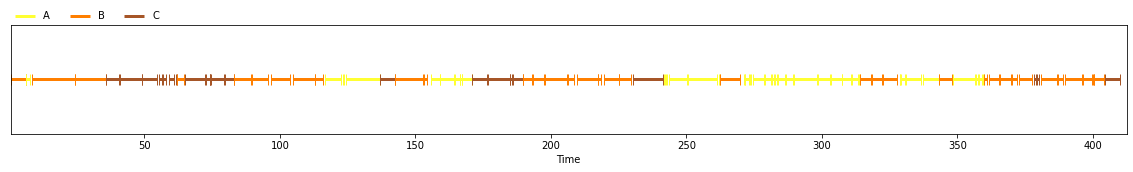

In [ ]:
diarization

In [ ]:
metric = DiarizationErrorRate()
metric(reference, diarization, detailed=True)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning:

'uem' was approximated by the union of 'reference' and 'hypothesis' extents.



{'confusion': 153.4279999999999,
 'correct': 195.8082499999997,
 'diarization error rate': 0.5600233021349015,
 'false alarm': 25.16768749999996,
 'missed detection': 38.603750000000225,
 'total': 387.83999999999986}

In [ ]:
report = metric.report(display=True)

      diarization error rate  total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                      %                       %                                 %                   %
item                                                                                                                             
file1                  54.67 905.88  556.70   61.45      146.07       16.13           287.68            31.76     61.50      6.79
TOTAL                  54.67 905.88  556.70   61.45      146.07       16.13           287.68            31.76     61.50      6.79


In [ ]:
report = metric.report(display=True)

      diarization error rate  total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                      %                       %                                 %                   %
item                                                                                                                             
file1                  56.00 387.84  195.81   50.49       25.17        6.49            38.60             9.95    153.43     39.56
TOTAL                  56.00 387.84  195.81   50.49       25.17        6.49            38.60             9.95    153.43     39.56


In [ ]:
!pip install ffmpeg-python

In [ ]:
time_labelling_to_rttm("annotation", "/content/out.rttm")

In [ ]:
import datetime

In [ ]:
date_time=datetime.datetime.strptime('00:00:55,830',"%H:%M:%S,%f")
a_timedelta = date_time - datetime.datetime(1900, 1, 1)
seconds = a_timedelta.total_seconds()

In [ ]:
seconds

55.83

https://github.com/kaldi-asr/kaldi/blob/master/egs/wsj/s5/steps/segmentation/convert_utt2spk_and_segments_to_rttm.py

In [ ]:
import ffmpeg
input = ffmpeg.input('/content/nashnote.mp3')
audio_trim = input.audio.filter('atrim', start=0, end=410)
output = ffmpeg.output(audio_trim, "/content/extract.wav")
output.run(capture_stdout=True, capture_stderr=True, overwrite_output=True)


(b'',
 b"ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers\n  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)\n  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid -

In [ ]:
pip install pyannote.audio==1.1.1

In [ ]:
pip install pyannote.core

In [ ]:
import torch
pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia_dihard')

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


  0%|          | 0.00/901 [00:00<?, ?B/s]

  0%|          | 0.00/1.49k [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


  0%|          | 0.00/2.41M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


  0%|          | 0.00/2.40M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


  0%|          | 0.00/16.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pyannote/audio/embedding/approaches/arcface_loss.py:170: FutureWarning:

The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release

/usr/local/lib/python3.7/dist-packages/pyannote/audio/features/pretrained.py:156: UserWarning:

Model was trained with 4s chunks and is applied on 2s chunks. This might lead to sub-optimal results.

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


In [ ]:
from pyannote.database import get_protocol
from pyannote.database import FileFinder
preprocessors = {'audio': FileFinder()}
protocol = get_protocol('AMI.SpeakerDiarization.MixHeadset',
                        preprocessors=preprocessors)
test_file = next(protocol.test())

In [ ]:
test_file = {'uri': 'filename', 'audio': '/content/extract.wav'}

In [ ]:
diarization = pipeline(test_file)

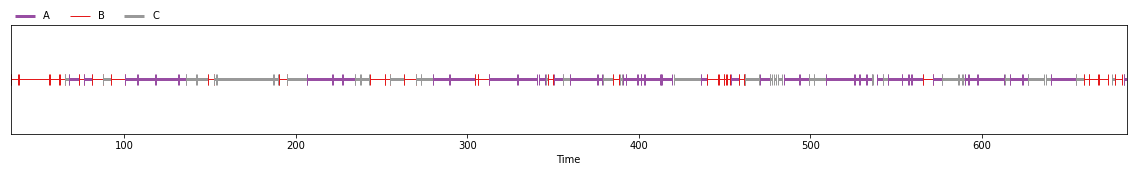

In [ ]:
diarization

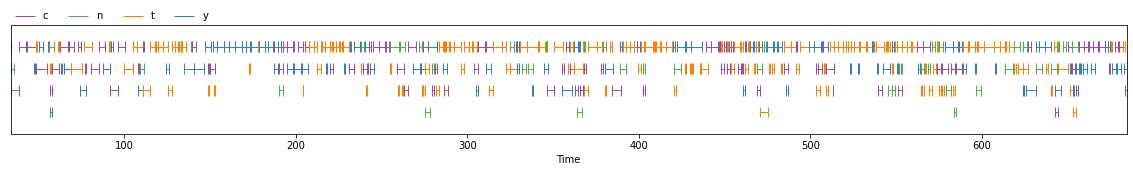

In [ ]:
reference